In [177]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0, "../")
sys.path.insert(0,"../pompjax/pompjax/")

from global_config import config

results_dir           = config.get_property('results_dir')
results2_dir           = config.get_property('results2_dir')

data_dir              = config.get_property('data_dir')
paper_dir             = config.get_property('paper_dir')
data_db_dir           = config.get_property('data_db_dir')
feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")

COLOR_LIST1           = ["#F8AFA8", "#FDDDA0", "#F5CDB4", "#74A089"]



In [178]:
from utils_data_metapop import create_population_data, create_time_transfers

path_to_ward_counts = os.path.join(data_db_dir, "long_files_8_25_2021", "counts_ward.csv" )
path_to_ward_transf = os.path.join(data_db_dir, "long_files_8_25_2021", "transfers_ward.csv" )

A_df, D_df, H_df, tests_df, Hmean_df = create_population_data(path_to_ward_counts)

num_wards  = len(Hmean_df)
ward_names = list(Hmean_df.index)
M_df       = create_time_transfers(path_to_ward_transf, num_wards=num_wards, ward_names=ward_names)


In [179]:
selected_buildings = ['Allen Hospital-Allen', 'Harkness Pavilion-Columbia', 'Milstein Hospital-Columbia', 'Mschony-Chony', 'Presbyterian Hospital-Columbia']
building2id        = {selected_buildings[i]: i for i in range(len(selected_buildings))}

def building2observation(building):
    if building in selected_buildings:
        return building2id[building]
    else:
        return 5

ward_names_df                = pd.DataFrame(ward_names, columns=["ward"])
ward_names_df["building"]    = ward_names_df["ward"].apply(lambda x: "-".join(x.split("-")[1:]))
ward_names_df["buidling_id"] = ward_names_df["building"].apply(lambda x: building2observation(x) )
ward_names_df["ward_id"]     = ward_names_df.apply(lambda x: np.where(ward_names_df.ward == x.ward)[0][0], axis=1)
wardid2buildingid            = {row.ward_id: row.buidling_id for i, row in ward_names_df.iterrows()}
ward2buildingid             =  {row.ward: row.buidling_id for i, row in ward_names_df.iterrows()}

# inferences not adjusting the state space, as with the ABM

In [180]:
from diagnostic_plots import convergence_plot
from utils import create_df_response
from ifeakf import ifeakf


def create_obs_building_amro(amro, model_settings, path_to_data, resample="W-Sun"):
    k                     = model_settings["k"]
    amro_df               = pd.read_csv(path_to_data, parse_dates=["date"]).drop(columns=["Unnamed: 0"])
    amro_df               = amro_df[amro_df["amro"]==amro]

    amro_df["buildingid"] = amro_df["ward_total"].map(ward2buildingid)
    amro_df               = amro_df.groupby(["date", "buildingid"]).sum(numeric_only=True).unstack([1]).resample(resample).sum(numeric_only=True).stack().reset_index()
    amro_df["obs_name"]   = amro_df["buildingid"].map({i: f"y{i+1}" for i in range(k)})
    amro_df               = pd.pivot(amro_df, index="date", columns="obs_name", values="num_positives").reset_index()
    for i in range(k):
        amro_df['oev'+str(i+1)] = 1 +(0.2 * amro_df['y'+str(i+1)].values)**2
    amro_df = amro_df.set_index("date")
    return amro_df



In [181]:

def run_inference_amro(f, f0, g, obs_df, model_settings, if_settings, id_run=0, path_to_save=None):

    ρmin              = 0.01 # test sensitivity minimum
    ρmax              = 0.2  # test sensitivity maximum
    βmin              = 0.00 # transmission rate minimum
    βmax              = 0.5  # transmission rate maximum

    state_space_range = model_settings["state_space_range"]
    parameters_range  = np.array([[ρmin, ρmax],    [βmin, βmax]])
    σ_perturb         = np.array([(ρmax - ρmin)/4, (βmax - βmin)/4]) # (i hve the gut feeling that 0.25 is too large)

    θmle, θpost = ifeakf(process_model                = f,
                            state_space_initial_guess = f0,
                            observational_model       = g,
                            observations_df           = obs_df,
                            parameters_range          = parameters_range,
                            state_space_range         = state_space_range,
                            model_settings            = model_settings,
                            if_settings               = if_settings,
                            perturbation              = σ_perturb)

    np.savez_compressed(os.path.join(path_to_save, f"{str(id_run).zfill(3)}posterior.npz"),
                                    mle           = θmle,
                                    posterior     = θpost)

    ρ_df = create_df_response(θpost[0, :, :, :].mean(-2).T, time=if_settings["Nif"])
    β_df = create_df_response(θpost[1, :, :, :].mean(-2).T, time=if_settings["Nif"])

    p_dfs             = [ρ_df, β_df]
    param_label       = ["ρ", "β"]
    parameters_range  = np.array([[ρmin, ρmax], [βmin, βmax]])
    convergence_plot(θmle, p_dfs, parameters_range, param_label,
                        path_to_save=os.path.join(path_to_save, f"{str(id_run).zfill(3)}convergence.png"))


In [182]:
from models import process_metapop, observe_metapop_cluster, init_metapop, simulate_metapop, simulate_metapop_observations
from utils_local.misc import amro2cute

delta = 1/120  # decolonization rate
A     = A_df.to_numpy()
D     = D_df.to_numpy()
H     = H_df.to_numpy()
M     = M_df
tests = tests_df.to_numpy()


In [183]:
from models import process_metapop, observe_metapop_cluster, init_metapop, simulate_metapop, simulate_metapop_observations
from utils_data_metapop import empirical_prevalence
from utils_local.misc import amro2cute

#### create scenarios ####
amro_search  = ['ESCHERICHIA COLI', 'KLEBSIELLA PNEUMONIAE',  'PSEUDOMONAS AERUGINOSA',
                'METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS', 'METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS',
                "STAPHYLOCOCCUS EPIDERMIDIS", 'ENTEROCOCCUS FAECALIS', 'ENTEROCOCCUS FAECIUM']

from utils_local.misc import amro2title

if_settings = {
        "Nif"                : 30,          # number of iterations of the IF
        "type_cooling"       : "geometric", # type of cooling schedule
        "shrinkage_factor"   : 0.9,         # shrinkage factor for the cooling schedule
        "inflation"          : 1.01         # inflation factor for spreading the variance after the EAKF step
        }

model_settings = {
    "param_name"  : ["ρ", "β"],       # importation and transmission rate
    "p"           : 2,                # number of parameters
    "dt"          : 1,                # time step
    "m"           : 300,              # number of ensembles
    "stochastic"  : True              # is stochastic
    }

dates_simulation = pd.date_range(start=pd.to_datetime("2020-02-01"), end=pd.to_datetime("2021-02-28"), freq="D")
num_pop          = num_wards

model_settings["n"]           = 3 * num_pop            # number of state variables / dimension of the state space
model_settings["T"]           = len(dates_simulation)  # time to run
model_settings["num_pop"]     = num_pop
model_settings["dates"]       = dates_simulation
model_settings["num_build"]   = len(np.unique(list(wardid2buildingid.values())))
model_settings["k"]           = model_settings["num_build"] # observing at the building aggregation

assim_dates                       = list(pd.date_range(start=pd.to_datetime("2020-02-01"), end=pd.to_datetime("2021-02-28"), freq="W-Sun"))
assim_dates[-1]                   = dates_simulation[-1]
if_settings["assimilation_dates"] = assim_dates
id_run                            = 0

path_to_amro = os.path.join(data_db_dir, "long_files_8_25_2021", "amro_ward.csv" )


for amro in amro_search:
    print("Running IF-EAKF for amro: ", amro2title(amro))

    obs_df       = create_obs_building_amro(amro, model_settings, path_to_amro, resample="W-Sun")
    path_to_save = os.path.join(results2_dir, "amro_inferences", "metapopulation", f"{amro2cute(amro)}")
    os.makedirs(path_to_save, exist_ok=True)
    gamma        = empirical_prevalence(amro, path_to_prev="../data/amro_prevalence.csv")

    if_settings["adjust_state_space"] = False
    path_to_samples = os.path.join(path_to_save, "no_adjust_state_space")
    os.makedirs(path_to_samples, exist_ok=True)

    if os.path.isfile(os.path.join(path_to_samples, f"{str(id_run).zfill(3)}posterior.npz")):
        continue

    max_total_pop     = np.max(H.sum(axis=0))
    model_settings["state_space_range"] = np.array([0, max_total_pop])

    init_state  = lambda θ:  init_metapop(N0               = H[:, 0],
                                            c0             = gamma,
                                            model_settings = model_settings)

    process  = lambda t, x, θ: process_metapop(t, x,
                                                gamma = gamma * np.ones(model_settings["m"]),
                                                beta  = θ[1, :],
                                                delta = delta,
                                                Nmean = np.expand_dims(Hmean_df, -1),
                                                N     = H[:, [t]],
                                                A     = A[:, [t]],
                                                D     = D[:, [t]],
                                                M     = M[:, :, t])

    obs_model = lambda t, x, θ: observe_metapop_cluster(t, x,
                                                    rho            = θ[0, :],
                                                    N              = H[:, [t]],
                                                    num_tests      = tests[:, [t]],
                                                    model_settings = model_settings,
                                                    ward2cluster   = wardid2buildingid)

    run_inference_amro(f               = process,
                        f0             = init_state,
                        g              = obs_model,
                        obs_df         = obs_df,
                        model_settings = model_settings,
                        if_settings    = if_settings,
                        id_run         = 0,
                        path_to_save   = path_to_samples)

Running IF-EAKF for amro:  E. coli
Running IF-EAKF for amro:  K. pneumoniae
Running IF-EAKF for amro:  P. aeruginosa
Running IF-EAKF for amro:  MSSA
Running IF-EAKF for amro:  MRSA
Running IF-EAKF for amro:  S. epidermidis
Running IF-EAKF for amro:  E. faecalis
Running IF-EAKF for amro:  E. faecium


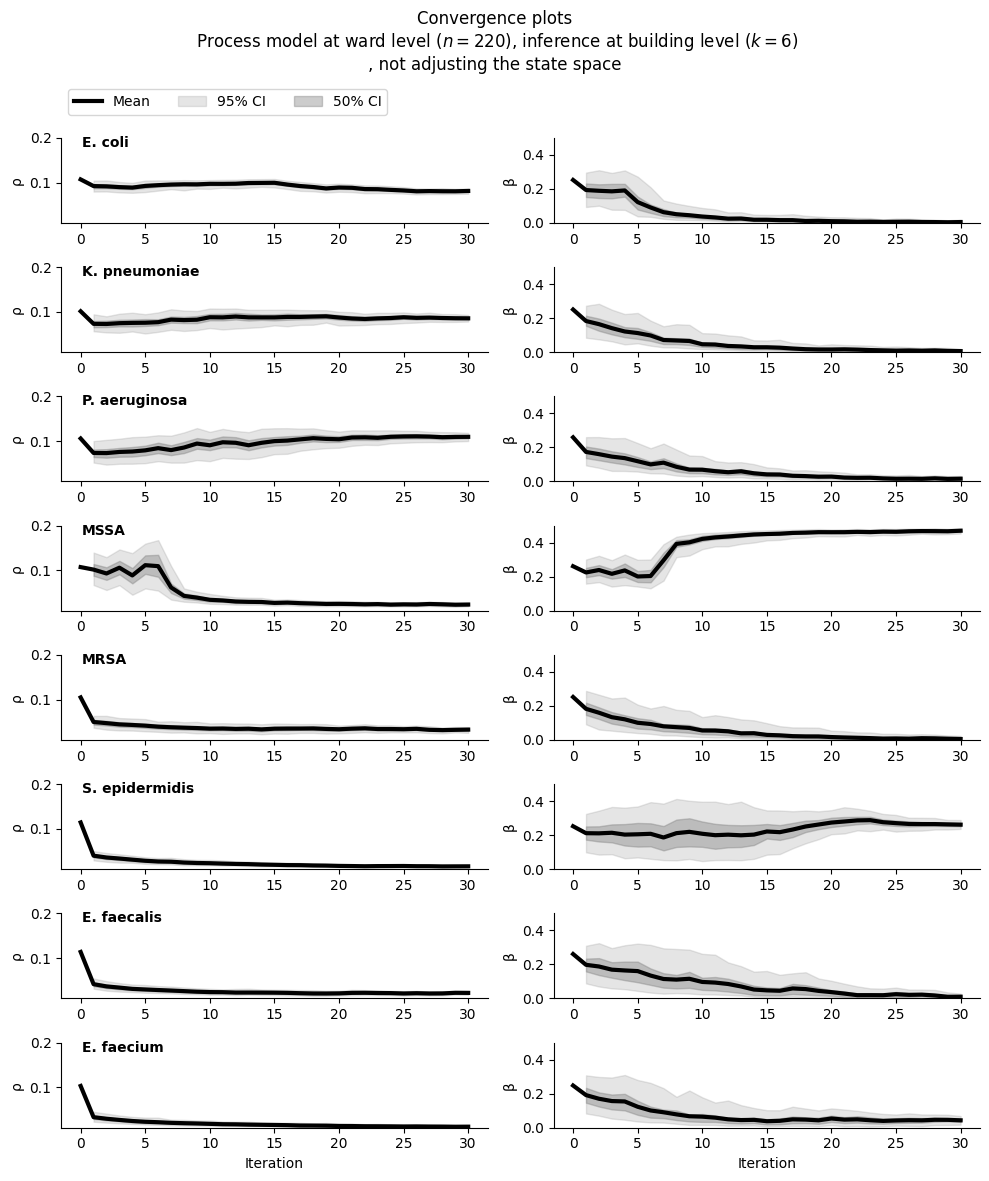

In [184]:
import matplotlib.pyplot as plt


posterior_df = pd.DataFrame()
mle_df       = pd.DataFrame()

fig, axes = plt.subplots(len(amro_search), 2, figsize=(10, 12))
for idx_amro, amro in enumerate(amro_search):
    path_to_samples   = os.path.join(results2_dir, "amro_inferences", "metapopulation", f"{amro2cute(amro)}", "no_adjust_state_space")
    samples_inference = np.load(os.path.join(path_to_samples, f"{str(id_run).zfill(3)}posterior.npz"))

    θpost = samples_inference["posterior"]
    θmle  = samples_inference["mle"]
    Nif   = θpost.shape[-1]
    θpost = θpost[:, :, :, :].mean(-2)

    p_last_df           = pd.DataFrame(columns=["value", "param", "ens_id", "amro"])
    p_last_df["value"]  = np.concatenate([θpost[0, :, -1], θpost[1, :, -1]])
    p_last_df["param"]  = ["ρ"] * model_settings["m"] + ["β"] * model_settings["m"]
    p_last_df["ens_id"] = list(range(model_settings["m"])) * 2
    p_last_df["amro"]   = amro
    mle_df              = pd.concat([mle_df, p_last_df])

    ρ_post = θpost[0, :, :].flatten()
    β_post = θpost[1, :, :].flatten()

    post_df            = pd.DataFrame(columns=["value", "param", "ens_id", "if_iter", "amro"])
    post_df["value"]   = np.concatenate([ρ_post, β_post])
    post_df["param"]   = ["ρ"] * len(ρ_post) + ["β"] * len(β_post)
    post_df["if_iter"] = flatten_list([list(range(Nif)) * model_settings["m"] ] * 2 )
    post_df["ens_id"]  = flatten_list([[i] * Nif for i in range( model_settings["m"])] * 2)
    post_df["amro"]    = amro
    posterior_df       = pd.concat([posterior_df, post_df])

    ρ_df = create_df_response(θpost[0, :, :].T, time=Nif)
    β_df = create_df_response(θpost[1, :, :].T, time=Nif)

    p_dfs             = [ρ_df, β_df]
    param_label       = ["ρ", "β"]

    parameters_range  = np.array([[0.01, 20/100], [0, 0.5]])
    convergence_plot(θmle, p_dfs, parameters_range, param_label, ax=axes[idx_amro, :], fig=fig, param_truth=None)
    axes[idx_amro, 0].legend().remove(); axes[idx_amro, 1].legend().remove()
    axes[idx_amro, 1].set_xlabel(None)
    axes[idx_amro, 0].spines['right'].set_visible(False)
    axes[idx_amro, 0].spines['top'].set_visible(False)

    axes[idx_amro, 1].spines['right'].set_visible(False)
    axes[idx_amro, 1].spines['top'].set_visible(False)
    axes[idx_amro, 0].text(x=0.1, y=0.18, s=f"{amro2title(amro)}", weight='bold')

axes[0, 0].legend(loc="upper left", bbox_to_anchor=(0.0, 1.65), ncol=4)
axes[-1, 0].set_xlabel("Iteration")
axes[-1, 1].set_xlabel("Iteration")

fig.suptitle(f"Convergence plots\n Process model at ward level ($n=220$), inference at building level ($k=6$)\n, not adjusting the state space", x=0.5)
plt.tight_layout()

/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_13877/1619976929.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v_df["amro_plot"] = v_df["amro"].map( amro2title )
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_13877/1619976929.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rho_df["value"] = rho_df["value"] * 100
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_13877/1619976929.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is depre

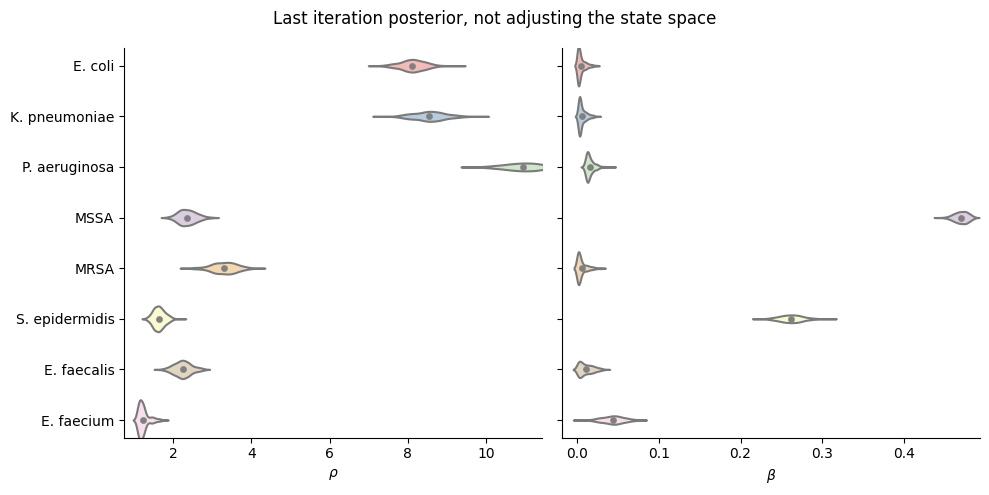

In [185]:
import seaborn as sns

v_df              = posterior_df[posterior_df["if_iter"] == Nif-1]
v_df["amro_plot"] = v_df["amro"].map( amro2title )
rho_df            = v_df[v_df["param"] == "ρ"]
beta_df           = v_df[v_df["param"] == "β"]

rho_df["value"] = rho_df["value"] * 100

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.violinplot(ax=ax[0], data=rho_df,  x="value", y="amro_plot", palette="Pastel1", inner=None, lw=1, ec="black")
sns.violinplot(ax=ax[1], data=beta_df, x="value", y="amro_plot", palette="Pastel1", inner=None, lw=1, ec="black")

amro2order =  {'E. coli': 0, 'K. pneumoniae': 1, 'P. aeruginosa': 2, 'MSSA': 3, 'MRSA': 4, 'S. epidermidis' : 5, 'E. faecalis' : 6, 'E. faecium' : 7}
rho_mean  = rho_df.groupby("amro_plot").mean().reset_index(); rho_mean["order"]   = rho_mean["amro_plot"].map( amro2order ); rho_mean = rho_mean.sort_values("order")
beta_mean = beta_df.groupby("amro_plot").mean().reset_index(); beta_mean["order"] = beta_mean["amro_plot"].map( amro2order ); beta_mean = beta_mean.sort_values("order")

sns.scatterplot(ax=ax[0], data=rho_mean,  x="value", y="amro_plot", fc="gray", ec="gray", s=20, lw=1.5)
sns.scatterplot(ax=ax[1], data=beta_mean,  x="value", y="amro_plot", fc="gray", ec="gray", s=20, lw=1.5)

ax[0].set_ylabel(None); ax[0].set_xlabel(r"$\rho$")
ax[1].set_ylabel(None); ax[1].set_xlabel(r"$\beta$")

for axi in ax:
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)

fig.suptitle(f"Last iteration posterior, not adjusting the state space", x=0.5)
plt.tight_layout()

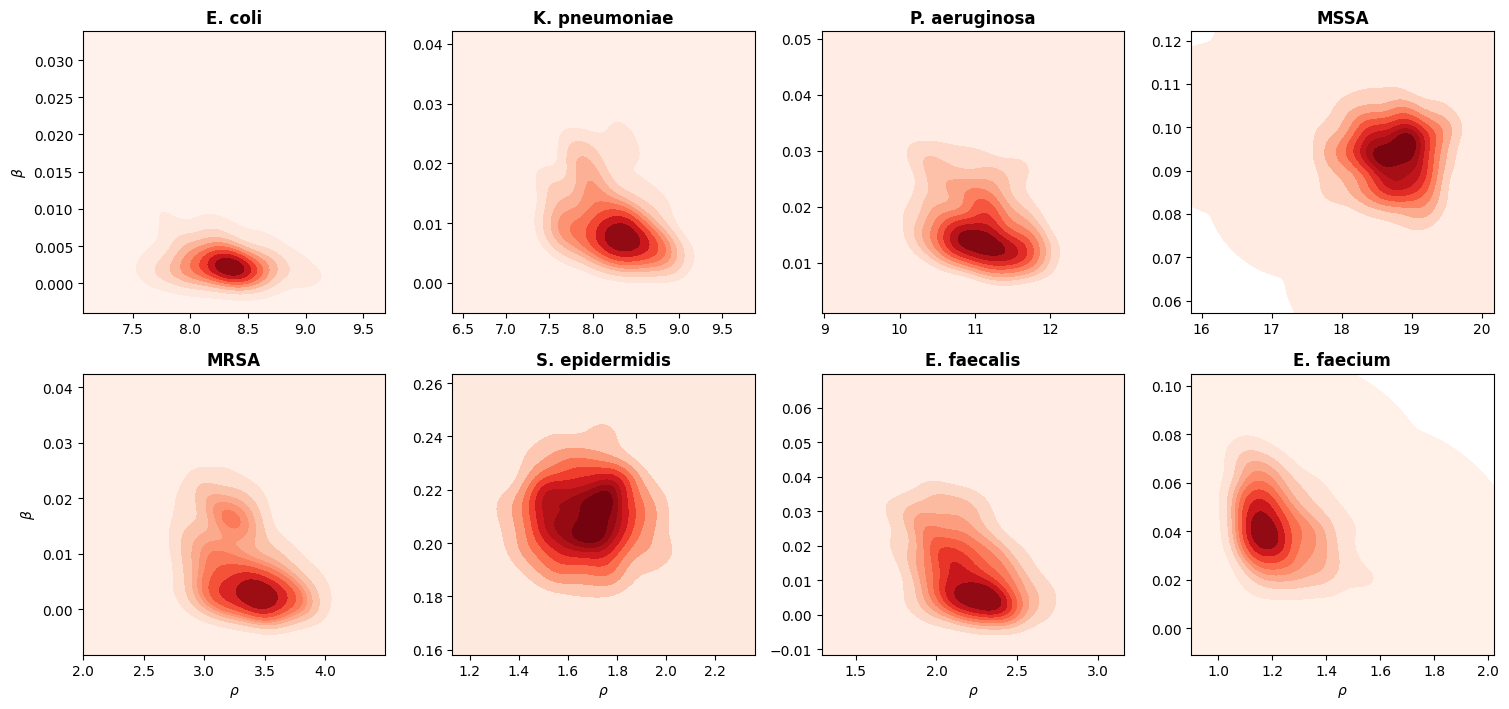

In [193]:

fig, axes = plt.subplots(2, 4, figsize=(15.2, 7.2), sharey=False, sharex=False)
for idx_amro, ax in enumerate(axes.flatten()):
    p_df              = v_df[v_df.amro==amro_search[idx_amro]]
    rho_df            = p_df[p_df["param"] == "ρ"].reset_index(drop=True)
    beta_df           = p_df[p_df["param"] == "β"].reset_index(drop=True)
    rho_df["value"]   = rho_df["value"] * 100

    sns.kdeplot(ax    = ax,
                x     = rho_df["value"],
                y     = beta_df["value"],
                cmap  = "Reds",
                fill = True,  thresh=0)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_title(f"{amro2title(amro_search[idx_amro])}", weight='bold')

axes[0, 0].set_ylabel(r"$\beta$"); axes[1, 0].set_ylabel(r"$\beta$")
for i in range(4):
    axes[1, i].set_xlabel(r"$\rho$")

plt.tight_layout()

# inferences * adjusting * the state space, as with the ABM

In [187]:
def process_model_wrapped(t, x, θ, f, model_settings):
    n       = model_settings["n"]
    m       = model_settings["m"]
    k       = model_settings["k"]
    num_pop = model_settings["num_pop"]

    x = np.reshape(x, ( int(n/num_pop), num_pop, m))
    x = f(t, x, θ)
    x = np.reshape(x, (n, m))

    return x

def obs_model_wrapped(t, x, θ, g, model_settings):
    n       = model_settings["n"]
    m       = model_settings["m"]
    k       = model_settings["k"]
    num_pop = model_settings["num_pop"]

    x = np.reshape(x, (int(n/num_pop), num_pop, m))
    x = g(t, x, θ)
    return x

def init_state_wrapped(θ, f0, model_settings):
    n = model_settings["n"]
    m = model_settings["m"]

    x = f0(θ)
    x = np.reshape(x, (n, m))
    return x

In [188]:
for amro in amro_search:
    print("Running IF-EAKF for amro: ", amro2title(amro))

    obs_df       = create_obs_building_amro(amro, model_settings, path_to_amro, resample="W-Sun")
    path_to_save = os.path.join(results2_dir, "amro_inferences", "metapopulation", f"{amro2cute(amro)}")
    os.makedirs(path_to_save, exist_ok=True)
    gamma        = empirical_prevalence(amro, path_to_prev="../data/amro_prevalence.csv")

    if_settings["adjust_state_space"] = True
    path_to_samples = os.path.join(path_to_save, "adjust_state_space")
    os.makedirs(path_to_samples, exist_ok=True)

    if os.path.isfile(os.path.join(path_to_samples, f"{str(id_run).zfill(3)}posterior.npz")):
        continue

    max_total_pop                       = np.max(H.sum(axis=0))
    model_settings["state_space_range"] = np.array([0, max_total_pop])

    f0          = lambda θ:  init_metapop(N0               = H[:, 0],
                                            c0             = gamma,
                                            model_settings = model_settings)
    init_state  = lambda θ: init_state_wrapped(θ, f0, model_settings)

    f  = lambda t, x, θ: process_metapop(t, x,
                                                gamma = gamma * np.ones(model_settings["m"]),
                                                beta  = θ[1, :],
                                                delta = delta,
                                                Nmean = np.expand_dims(Hmean_df, -1),
                                                N     = H[:, [t]],
                                                A     = A[:, [t]],
                                                D     = D[:, [t]],
                                                M     = M[:, :, t])
    process  = lambda t, x, θ: process_model_wrapped(t, x, θ, f, model_settings)

    g = lambda t, x, θ: observe_metapop_cluster(t, x,
                                                    rho            = θ[0, :],
                                                    N              = H[:, [t]],
                                                    num_tests      = tests[:, [t]],
                                                    model_settings = model_settings,
                                                    ward2cluster   = wardid2buildingid)
    obs_model = lambda t, x, θ: obs_model_wrapped(t, x, θ, g, model_settings)
    run_inference_amro(f               = process,
                        f0             = init_state,
                        g              = obs_model,
                        obs_df         = obs_df,
                        model_settings = model_settings,
                        if_settings    = if_settings,
                        id_run         = 0,
                        path_to_save   = path_to_samples)
    plt.close()


Running IF-EAKF for amro:  E. coli
Running IF-EAKF for amro:  K. pneumoniae
Running IF-EAKF for amro:  P. aeruginosa
Running IF-EAKF for amro:  MSSA
Running IF-EAKF for amro:  MRSA
Running IF-EAKF for amro:  S. epidermidis
Running IF-EAKF for amro:  E. faecalis
Running IF-EAKF for amro:  E. faecium


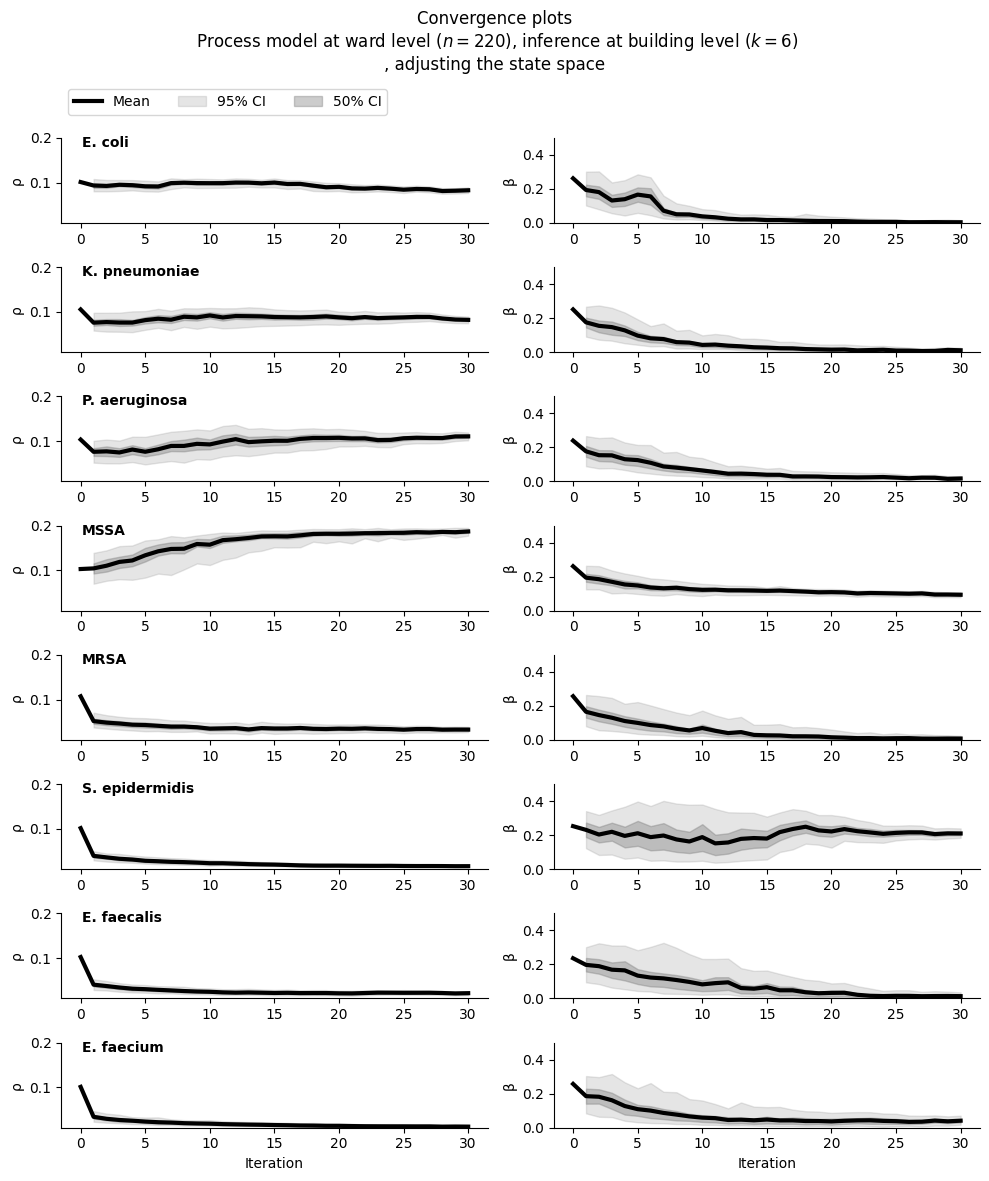

In [189]:
import matplotlib.pyplot as plt


posterior_df = pd.DataFrame()
mle_df       = pd.DataFrame()

fig, axes = plt.subplots(len(amro_search), 2, figsize=(10, 12))
for idx_amro, amro in enumerate(amro_search):
    path_to_samples   = os.path.join(results2_dir, "amro_inferences", "metapopulation", f"{amro2cute(amro)}", "adjust_state_space")
    samples_inference = np.load(os.path.join(path_to_samples, f"{str(id_run).zfill(3)}posterior.npz"))

    θpost = samples_inference["posterior"]
    θmle  = samples_inference["mle"]
    Nif   = θpost.shape[-1]
    θpost = θpost[:, :, :, :].mean(-2)

    p_last_df           = pd.DataFrame(columns=["value", "param", "ens_id", "amro"])
    p_last_df["value"]  = np.concatenate([θpost[0, :, -1], θpost[1, :, -1]])
    p_last_df["param"]  = ["ρ"] * model_settings["m"] + ["β"] * model_settings["m"]
    p_last_df["ens_id"] = list(range(model_settings["m"])) * 2
    p_last_df["amro"]   = amro
    mle_df              = pd.concat([mle_df, p_last_df])

    ρ_post = θpost[0, :, :].flatten()
    β_post = θpost[1, :, :].flatten()

    post_df            = pd.DataFrame(columns=["value", "param", "ens_id", "if_iter", "amro"])
    post_df["value"]   = np.concatenate([ρ_post, β_post])
    post_df["param"]   = ["ρ"] * len(ρ_post) + ["β"] * len(β_post)
    post_df["if_iter"] = flatten_list([list(range(Nif)) * model_settings["m"] ] * 2 )
    post_df["ens_id"]  = flatten_list([[i] * Nif for i in range( model_settings["m"])] * 2)
    post_df["amro"]    = amro
    posterior_df       = pd.concat([posterior_df, post_df])

    ρ_df = create_df_response(θpost[0, :, :].T, time=Nif)
    β_df = create_df_response(θpost[1, :, :].T, time=Nif)

    p_dfs             = [ρ_df, β_df]
    param_label       = ["ρ", "β"]

    parameters_range  = np.array([[0.01, 20/100], [0, 0.5]])
    convergence_plot(θmle, p_dfs, parameters_range, param_label, ax=axes[idx_amro, :], fig=fig, param_truth=None)
    axes[idx_amro, 0].legend().remove(); axes[idx_amro, 1].legend().remove()
    axes[idx_amro, 1].set_xlabel(None)
    axes[idx_amro, 0].spines['right'].set_visible(False)
    axes[idx_amro, 0].spines['top'].set_visible(False)

    axes[idx_amro, 1].spines['right'].set_visible(False)
    axes[idx_amro, 1].spines['top'].set_visible(False)
    axes[idx_amro, 0].text(x=0.1, y=0.18, s=f"{amro2title(amro)}", weight='bold')

axes[0, 0].legend(loc="upper left", bbox_to_anchor=(0.0, 1.65), ncol=4)
axes[-1, 0].set_xlabel("Iteration")
axes[-1, 1].set_xlabel("Iteration")

fig.suptitle(f"Convergence plots\n Process model at ward level ($n=220$), inference at building level ($k=6$)\n, adjusting the state space", x=0.5)
plt.tight_layout()


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_13877/3722012513.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v_df["amro_plot"] = v_df["amro"].map( amro2title )
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_13877/3722012513.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rho_df["value"]   = rho_df["value"] * 100
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_13877/3722012513.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is dep

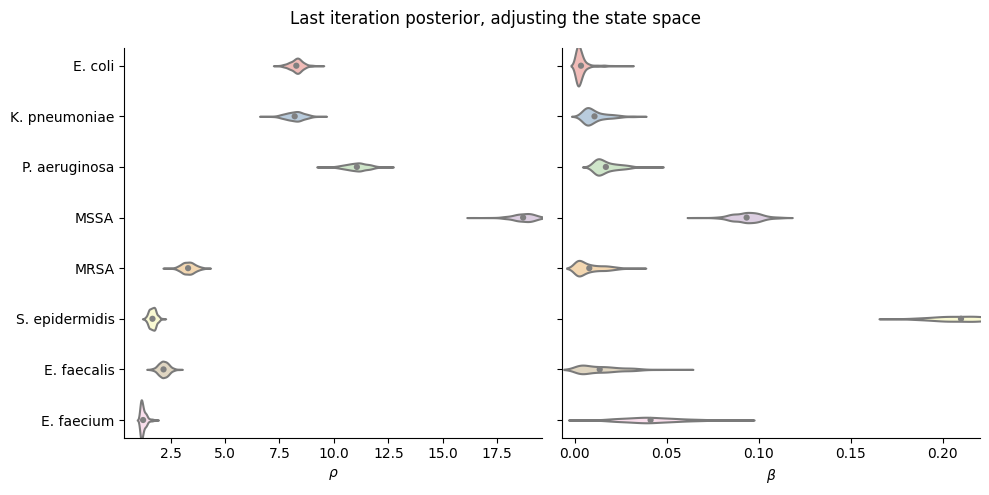

In [190]:
import seaborn as sns

v_df              = posterior_df[posterior_df["if_iter"] == Nif-1]
v_df["amro_plot"] = v_df["amro"].map( amro2title )
rho_df            = v_df[v_df["param"] == "ρ"]
beta_df           = v_df[v_df["param"] == "β"]
rho_df["value"]   = rho_df["value"] * 100

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.violinplot(ax=ax[0], data=rho_df,  x="value", y="amro_plot", palette="Pastel1", inner=None, lw=0.5, color="k")
sns.violinplot(ax=ax[1], data=beta_df, x="value", y="amro_plot", palette="Pastel1", inner=None, lw=0.5, color="k")

amro2order =  {'E. coli': 0, 'K. pneumoniae': 1, 'P. aeruginosa': 2, 'MSSA': 3, 'MRSA': 4, 'S. epidermidis' : 5, 'E. faecalis' : 6, 'E. faecium' : 7}
rho_mean  = rho_df.groupby("amro_plot").mean().reset_index(); rho_mean["order"]   = rho_mean["amro_plot"].map( amro2order ); rho_mean = rho_mean.sort_values("order")
beta_mean = beta_df.groupby("amro_plot").mean().reset_index(); beta_mean["order"] = beta_mean["amro_plot"].map( amro2order ); beta_mean = beta_mean.sort_values("order")

sns.scatterplot(ax=ax[0], data=rho_mean,  x="value", y="amro_plot", fc="gray", ec=None, s=20)
sns.scatterplot(ax=ax[1], data=beta_mean,  x="value", y="amro_plot", fc="gray", ec=None, s=20)

ax[0].set_ylabel(None); ax[0].set_xlabel(r"$\rho$")
ax[1].set_ylabel(None); ax[1].set_xlabel(r"$\beta$")

for axi in ax:
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)

fig.suptitle(f"Last iteration posterior, adjusting the state space", x=0.5)
plt.tight_layout()

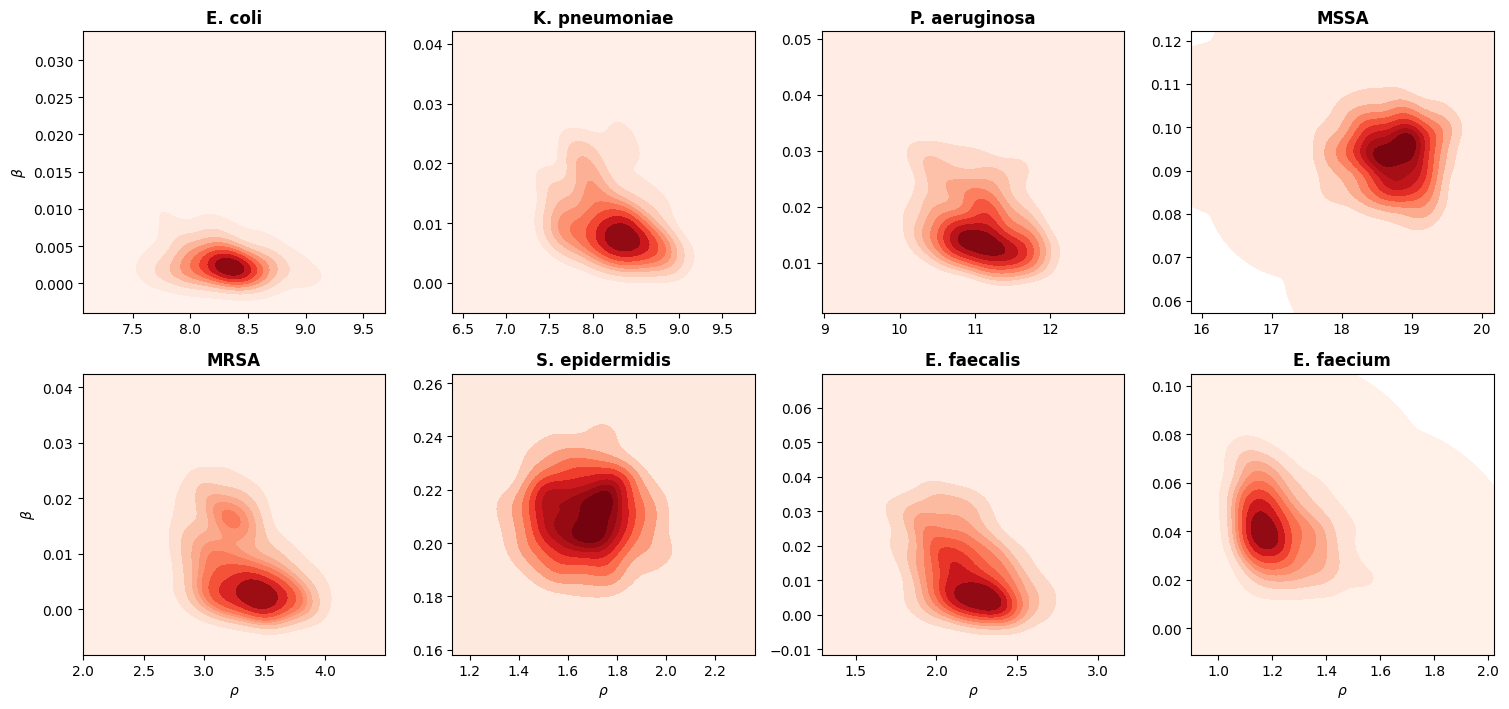

In [192]:

fig, axes = plt.subplots(2, 4, figsize=(15.2, 7.2), sharey=False, sharex=False)
for idx_amro, ax in enumerate(axes.flatten()):
    p_df              = v_df[v_df.amro==amro_search[idx_amro]]
    rho_df            = p_df[p_df["param"] == "ρ"].reset_index(drop=True)
    beta_df           = p_df[p_df["param"] == "β"].reset_index(drop=True)
    rho_df["value"]   = rho_df["value"] * 100

    sns.kdeplot(ax    = ax,
                x     = rho_df["value"],
                y     = beta_df["value"],
                cmap  = "Reds",
                fill = True,  thresh=0)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_title(f"{amro2title(amro_search[idx_amro])}", weight='bold')

axes[0, 0].set_ylabel(r"$\beta$"); axes[1, 0].set_ylabel(r"$\beta$")
for i in range(4):
    axes[1, i].set_xlabel(r"$\rho$")

plt.tight_layout()